In [1]:
# tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import load_model
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score

In [4]:
# loading the archiecture of "inception_resnet_v1"

def load_model():
    model_path = "tf_files\\keras-facenet-tf23"
    model = tf.keras.models.load_model(model_path)
    model.load_weights('tf_files\\keras-facenet-h5\\model.h5')
    return model

targeted_model = load_model()

In [5]:
targeted_model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

In [6]:
# loading data from directory

import tensorflow as tf
# generators
trainn_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Adversarial_Evasion_Attack\\train_casia',
    labels='inferred',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(160,160)
)

validationn_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Adversarial_Evasion_Attack\\test_casia',
    labels='inferred',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(160,160)
)

Found 388297 files belonging to 10572 classes.
Found 102326 files belonging to 10572 classes.


In [7]:
# Normalize the images
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

trainn_ds = trainn_ds.map(process)
validationn_ds = validationn_ds.map(process)

In [8]:
# loading the model again by romving last 5 layers
def load_model():
    model_path = "tf_files\\keras-facenet-tf23"
    model = tf.keras.models.load_model(model_path)
    model.load_weights('tf_files\\keras-facenet-h5\\model.h5')
    base_model = tf.keras.Model(inputs = model.input, outputs = model.layers[-5].output)
    return base_model

base_model = load_model()

In [9]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                              

(160, 160, 3)


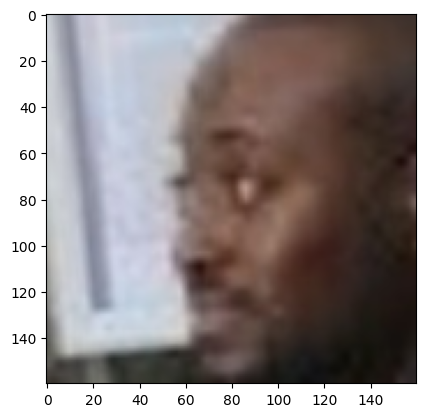

In [10]:
import matplotlib.pyplot as plt
for i, j in trainn_ds.take(1):
    print(i[1].shape)
    image = i[1]
    plt.imshow(image)
    plt.show()

In [11]:
# make all the remaining layers false for training
for layers in base_model.layers:
    layers.trainable = False
    print(layers.name, layers.trainable)    

input_1 False
Conv2d_1a_3x3 False
Conv2d_1a_3x3_BatchNorm False
Conv2d_1a_3x3_Activation False
Conv2d_2a_3x3 False
Conv2d_2a_3x3_BatchNorm False
Conv2d_2a_3x3_Activation False
Conv2d_2b_3x3 False
Conv2d_2b_3x3_BatchNorm False
Conv2d_2b_3x3_Activation False
MaxPool_3a_3x3 False
Conv2d_3b_1x1 False
Conv2d_3b_1x1_BatchNorm False
Conv2d_3b_1x1_Activation False
Conv2d_4a_3x3 False
Conv2d_4a_3x3_BatchNorm False
Conv2d_4a_3x3_Activation False
Conv2d_4b_3x3 False
Conv2d_4b_3x3_BatchNorm False
Conv2d_4b_3x3_Activation False
Block35_1_Branch_2_Conv2d_0a_1x1 False
Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm False
Block35_1_Branch_2_Conv2d_0a_1x1_Activation False
Block35_1_Branch_1_Conv2d_0a_1x1 False
Block35_1_Branch_2_Conv2d_0b_3x3 False
Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm False
Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm False
Block35_1_Branch_1_Conv2d_0a_1x1_Activation False
Block35_1_Branch_2_Conv2d_0b_3x3_Activation False
Block35_1_Branch_0_Conv2d_1x1 False
Block35_1_Branch_1_Conv2d_0b_

In [12]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Softmax

In [13]:
#Self defined layers for training
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(10572, activation='softmax')(x)

In [14]:
finetuned_model = tf.keras.Model(inputs =base_model.input,outputs = predictions )

In [15]:
from tensorflow.keras.optimizers import Adam

In [16]:
# compile
finetuned_model.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
# model training
fine_tunned_facenet = finetuned_model.fit(
    trainn_ds,
    epochs=30,
    validation_data=validationn_ds
)

Epoch 1/30
12135/12135 [==============================] - 2289s 188ms/step - loss: 9.0717 - accuracy: 0.0391 - val_loss: 8.7888 - val_accuracy: 0.0808
Epoch 2/30
12135/12135 [==============================] - 855s 70ms/step - loss: 8.4951 - accuracy: 0.0744 - val_loss: 8.1410 - val_accuracy: 0.0744
Epoch 3/30
12135/12135 [==============================] - 890s 73ms/step - loss: 7.8466 - accuracy: 0.0820 - val_loss: 7.5058 - val_accuracy: 0.0922
Epoch 4/30
12135/12135 [==============================] - 880s 72ms/step - loss: 7.2265 - accuracy: 0.1116 - val_loss: 6.9100 - val_accuracy: 0.1301
Epoch 5/30
12135/12135 [==============================] - 863s 71ms/step - loss: 6.6466 - accuracy: 0.1543 - val_loss: 6.3613 - val_accuracy: 0.1749
Epoch 6/30
12135/12135 [==============================] - 932s 77ms/step - loss: 6.1131 - accuracy: 0.2010 - val_loss: 5.8620 - val_accuracy: 0.2224
Epoch 7/30
12135/12135 [==============================] - 844s 70ms/step - loss: 5.6259 - accuracy: 0.24

In [ ]:
# Define metrics for Top-1 and Top-5 accuracy
top_1_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
top_5_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=5)

# Evaluate the model on the test dataset
for images, one_hot_labels in validationn_ds:
    predictions = finetuned_model(images)
    top_1_accuracy.update_state(one_hot_labels, predictions)
    top_5_accuracy.update_state(one_hot_labels, predictions)

# Get the final accuracy results
top_1_result = top_1_accuracy.result().numpy()
top_5_result = top_5_accuracy.result().numpy()

print(f'Top-1 Accuracy: {top_1_result:.4f}')
print(f'Top-5 Accuracy: {top_5_result:.4f}')

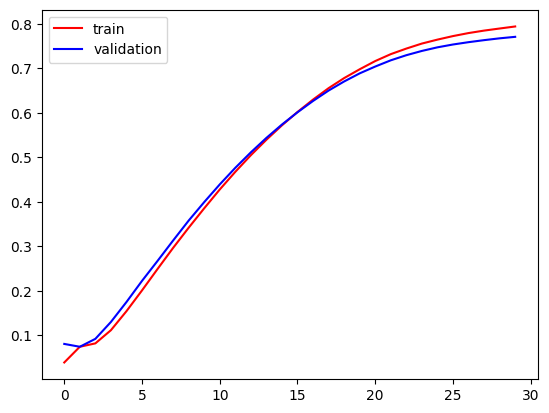

In [18]:
import matplotlib.pyplot as plt

plt.plot(fine_tunned_facenet.history['accuracy'],color='red',label='train')
plt.plot(fine_tunned_facenet.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

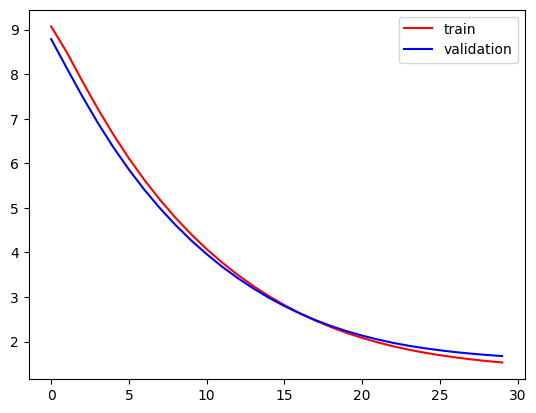

In [19]:
plt.plot(fine_tunned_facenet.history['loss'],color='red',label='train')
plt.plot(fine_tunned_facenet.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [20]:
finetuned_model.save("D:\Internship\inception_casia")

INFO:tensorflow:Assets written to: D:\Internship\inception_casia\assets


INFO:tensorflow:Assets written to: D:\Internship\inception_casia\assets


In [21]:
fine_tunned_inception = tf.keras.models.load_model("D:\Internship\inception_casia")

1/1 [==============================] - 2s 2s/step


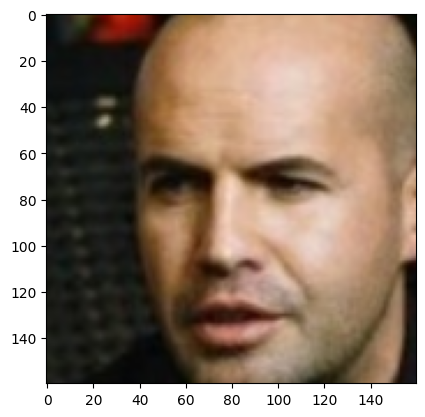

True Label: 279
Predicted Label: 279, Confidence: 0.9879459142684937


In [22]:

for images, labels in validationn_ds.take(1):
    input_image = images[0]
    true_label = labels[0]
    true_label_index = np.argmax(true_label)
    prediction = fine_tunned_inception.predict(np.expand_dims(input_image, axis=0))
    predicted_label = np.argmax(prediction)
    confidence = np.max(prediction)
    plt.imshow(input_image)
    plt.show()
    print(f"True Label: {true_label_index}")
    print(f"Predicted Label: {predicted_label}, Confidence: {confidence}")

In [23]:
# check all the layers
for i, layer in enumerate(fine_tunned_inception.layers):
   print(i, layer.name)


0 input_1
1 Conv2d_1a_3x3
2 Conv2d_1a_3x3_BatchNorm
3 Conv2d_1a_3x3_Activation
4 Conv2d_2a_3x3
5 Conv2d_2a_3x3_BatchNorm
6 Conv2d_2a_3x3_Activation
7 Conv2d_2b_3x3
8 Conv2d_2b_3x3_BatchNorm
9 Conv2d_2b_3x3_Activation
10 MaxPool_3a_3x3
11 Conv2d_3b_1x1
12 Conv2d_3b_1x1_BatchNorm
13 Conv2d_3b_1x1_Activation
14 Conv2d_4a_3x3
15 Conv2d_4a_3x3_BatchNorm
16 Conv2d_4a_3x3_Activation
17 Conv2d_4b_3x3
18 Conv2d_4b_3x3_BatchNorm
19 Conv2d_4b_3x3_Activation
20 Block35_1_Branch_2_Conv2d_0a_1x1
21 Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm
22 Block35_1_Branch_2_Conv2d_0a_1x1_Activation
23 Block35_1_Branch_1_Conv2d_0a_1x1
24 Block35_1_Branch_2_Conv2d_0b_3x3
25 Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm
26 Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm
27 Block35_1_Branch_1_Conv2d_0a_1x1_Activation
28 Block35_1_Branch_2_Conv2d_0b_3x3_Activation
29 Block35_1_Branch_0_Conv2d_1x1
30 Block35_1_Branch_1_Conv2d_0b_3x3
31 Block35_1_Branch_2_Conv2d_0c_3x3
32 Block35_1_Branch_0_Conv2d_1x1_BatchNorm
33 Block35_1_B

In [24]:
for layer in fine_tunned_inception.layers[:327]:
   layer.trainable = False
for layer in fine_tunned_inception.layers[327:]:
   layer.trainable = True

In [25]:
from keras.optimizers import Adam

fine_tunned_inception.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics= ["accuracy"])

c:\Users\IDEA Lab\.conda\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [26]:
# re-training
fine_tunned_inception1 = fine_tunned_inception.fit(trainn_ds, epochs= 4, validation_data = validationn_ds )

Epoch 1/4
12135/12135 [==============================] - 1007s 82ms/step - loss: 1.6795 - accuracy: 0.7679 - val_loss: 1.4933 - val_accuracy: 0.7963
Epoch 2/4
12135/12135 [==============================] - 1001s 82ms/step - loss: 1.1750 - accuracy: 0.8402 - val_loss: 1.3640 - val_accuracy: 0.8116
Epoch 3/4
12135/12135 [==============================] - 1001s 83ms/step - loss: 0.9345 - accuracy: 0.8726 - val_loss: 1.3613 - val_accuracy: 0.8106
Epoch 4/4
12135/12135 [==============================] - 1002s 83ms/step - loss: 0.7497 - accuracy: 0.8970 - val_loss: 1.3823 - val_accuracy: 0.8101


In [29]:
# Define metrics for Top-1 and Top-5 accuracy
top_1_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
top_5_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=5)

# Evaluate the model on the test dataset
for images, one_hot_labels in validationn_ds:
    predictions = fine_tunned_inception(images)
    top_1_accuracy.update_state(one_hot_labels, predictions)
    top_5_accuracy.update_state(one_hot_labels, predictions)

# Get the final accuracy results
top_1_result = top_1_accuracy.result().numpy()
top_5_result = top_5_accuracy.result().numpy()

print(f'Top-1 Accuracy: {top_1_result:.4f}')
print(f'Top-5 Accuracy: {top_5_result:.4f}')

Top-1 Accuracy: 0.8101
Top-5 Accuracy: 0.8724


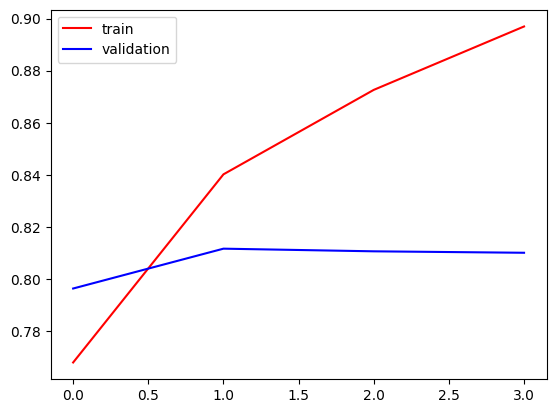

In [27]:
plt.plot(fine_tunned_inception1.history['accuracy'],color='red',label='train')
plt.plot(fine_tunned_inception1.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

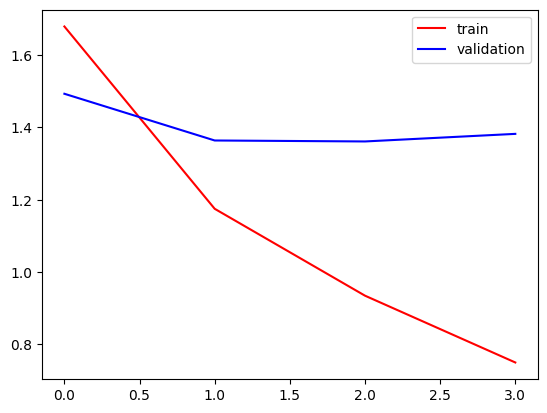

In [28]:
plt.plot(fine_tunned_inception1.history['loss'],color='red',label='train')
plt.plot(fine_tunned_inception1.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()